## Juntar tablas de diferentes años, seleccionar atributos más relevantes y generar promedios móviles de las Partículas PM

En este notebook se juntan los archivos de contaminación y meteorología de cada año en un solo dataframe. Adicionalmente vamos a generar columnas de información temporal para cada medición y por úlitmo se va a obtener el promedio móvil de el PM10 y PM2.5. 

__Pasos y descripción general del notebook__


1. Juntar los datos de las mediciones por año en un solo dataframe con el objetivo de agilizar su manipulación.


2. También se deshecharan las columnas "PBa","PMCO","UVA","UVB" y "WDR" debido a que éstos atributos no son compartidos en tiempo real por lo que no es posible hacer uso de éstas para el pronóstico. En el caso de "WDR" si se comparte en tiempo real sin embargo, se concluyó que este no aporta información a la descripción del fenómeno. 


3. Generar columnas con información temporal como la hora, día y mes en que se generó la medición, estos atributos son de ultilidad para utilizar los patrones temporales de temporalidad en el fenómeno de contaminación.


4. Se filtran los valores de PM10 y PM2.5 que salen del percentil .85. 


5. Por último generamos el atributo PM10mean y PM25mean que representarán el promedio móvil de las últimas 24 horas de los dos contaminantes.


- __Datos recibidos:__ Limpieza de datos inicial
- __Responsable:__ Daniel Bustillos
- __Contacto:__  juandaniel.bucam@gmail.com


In [29]:
import numpy as np
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 

## 1. 
### Juntar los datos de las mediciones por año en un solo dataframe con el objetivo de agilizar su manipulación.

Declaramos los nombres de todos los años con los que se generarán los modelos en una lista:

In [30]:
lista = ["cont_hora2000.csv" ,"cont_hora2001.csv","cont_hora2002.csv", "cont_hora2003.csv",
         "cont_hora2004.csv","cont_hora2005.csv" , "cont_hora2006.csv","cont_hora2007.csv",
         "cont_hora2008.csv", "cont_hora2009.csv","cont_hora2010.csv","cont_hora2011.csv",
        "cont_hora2012.csv","cont_hora2013.csv","cont_hora2014.csv","cont_hora2015.csv",
         "cont_hora2016.csv", "cont_hora2017.csv", "cont_hora2018.csv", "cont_hora2019.csv"] #verification_set

Leemos los archivos y creamos un diccionario donde cada entrada es un el dataframe de un año en específico:

In [31]:
dir_files = "/DATA/paw/jupyterhub_notebook/daniel.bustillos/DanielBustillos/contaminación/datasets/por_hora/"

In [32]:
data_hora = {}
for elem in lista:
    data_hora[elem[9:13]] = pd.read_csv(str(dir_files + elem))
    data_hora[elem[9:13]] = data_hora[elem[9:13]].iloc[:,1:]

Creamos unn dataframe y juntamos todos los años en este:

In [33]:
columnas_df_append = [ 'RH', 'TMP', 'WSP', 'id_station', 'fecha', 'CO', 'NO',
       'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'SO2', 'hora', 'dia', 'mes']

In [34]:
df_append = pd.DataFrame(columns=columnas_df_append)#change to 2019
for key in data_hora:
    df_append = df_append.append(data_hora[key], ignore_index=True,sort=True)

In [ ]:
df_append['hora'] = df_append['hora'].astype(str).astype(float)

sns.distplot(df_append["hora"], bins=24, kde=False, rug=True);

##  Los siguientes atributos son asignnados a objetos, necesitamos convertir estos atributos a float:

In [11]:
df_append["PM2.5"] = df_append["PM2.5"].astype(float)
df_append["NO"] = df_append["NO"].astype(float)

Ordenemos el DF por fecha y estación de manera ascendente en ambos casos:

In [12]:
df_append = df_append.sort_values(['id_station','fecha'], ascending=[1, 1]).reset_index(drop=True)

In [13]:
df_append.head(5)

,CO,NO,NO2,NOX,O3,PBa,PM10,PM2.5,PMCO,RH,SO2,TMP,WDR,WSP,dia,fecha,hora,id_station,mes
0,NaN,NaN,NaN,NaN,33.0,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,20,2007-07-20,9,ACO,7
1,NaN,NaN,NaN,NaN,45.0,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,20,2007-07-20,10,ACO,7
2,NaN,NaN,NaN,NaN,58.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,20,2007-07-20,11,ACO,7
3,NaN,NaN,NaN,NaN,69.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,20,2007-07-20,12,ACO,7
4,NaN,NaN,NaN,NaN,67.0,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,20,2007-07-20,13,ACO,7


In [17]:
import seaborn as sns

ValueError: color kwarg must have one color per data set. 4978530 data sets and 1 colors were provided

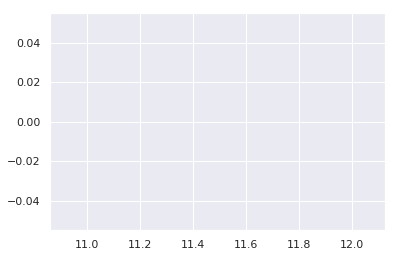

In [18]:
sns.distplot(df_append["hora"], bins=20, kde=False, rug=True);

## 2. 
### También se deshecharan las columnas "PBa","PMCO","UVA","UVB" y "WDR" debido a que éstos atributos non se comparten en tiempo real por lo que no es posible ocuparlas para el pronóstico, en el caso de "WDR" si se comparte en tiempo real sin embargo, se concluyó que este no aporta a la descripción del fenómeno. 

Eliminamos los atributos mencionados:

In [19]:
df_append = df_append[[ 'RH', 'TMP', 'WSP', 'id_station', 'fecha', 'CO', 'NO',
       'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'SO2', 'hora', 'dia', 'mes']].reset_index(drop=True)

## 3. 
### Generar columnas con información temporal como la hora, día y mes en que se generó la medición, estos atributos son de ultilidad para utilizar los patrones temporaloes de temporalidad en el fenómeno de contaminación.m

Arreglamos las fechas, vamos a generar columnas con el atributo hora,dia,mes.

In [20]:
df_append['dia'] = df_append['fecha'].astype(str).str[8:10]
df_append['mes'] =  df_append['fecha'].astype(str).str[5:7]
df_append['fecha'] = df_append['fecha'].astype(str).str[0:10]
df_append['dia'] = df_append['dia'].astype(str).astype(float)
df_append['mes'] = df_append['mes'].astype(str).astype(float)

Creamos una columna con toda esta información temporal, esta columna es de utilidad al ordenar y efectuar otras operaciones sobre el dataframe donde es necesario tener el orden de las mediciones bien definida.

In [21]:
df_append['fecha']  = pd.to_datetime([''.join([' '.join([df_append.loc[i, 'fecha'], 
                                                         str(df_append.loc[i, 'hora'])]),':00']) for i in df_append.index])
df_append['fecha'] = pd.to_datetime(df_append['fecha'], format='%Y-%m-%d %H:%M:%S')

In [22]:
df_append.head()

,RH,TMP,WSP,id_station,fecha,CO,NO,NO2,NOX,O3,PM10,PM2.5,SO2,hora,dia,mes
0,NaN,NaN,NaN,ACO,2007-07-20 09:00:00,NaN,NaN,NaN,NaN,33.0,NaN,17.0,NaN,9,20.0,7.0
1,NaN,NaN,NaN,ACO,2007-07-20 10:00:00,NaN,NaN,NaN,NaN,45.0,NaN,14.0,NaN,10,20.0,7.0
2,NaN,NaN,NaN,ACO,2007-07-20 11:00:00,NaN,NaN,NaN,NaN,58.0,NaN,15.0,NaN,11,20.0,7.0
3,NaN,NaN,NaN,ACO,2007-07-20 12:00:00,NaN,NaN,NaN,NaN,69.0,NaN,15.0,NaN,12,20.0,7.0
4,NaN,NaN,NaN,ACO,2007-07-20 13:00:00,NaN,NaN,NaN,NaN,67.0,NaN,21.0,NaN,13,20.0,7.0


## 4. 
### Se filtran los valores de PM10 y PM2.5 que salen del percentil .85. 

Vemos que tenemos valores muy grandes, Jiang (2004) reportó que para valores mayores de 300 puntos, las mediciones no son confiables, vamos a quedarnos con mediciones menores a esta cota:

__Jiang, D., Zhang, Y., Hu, X., Zeng, Y., Tan, J., & Shao, D. (2004). Progress in developing an ANN model for air pollution index forecast. Atmospheric Environment, 38(40 SPEC.ISS.), 7055–7064. https://doi.org/10.1016/j.atmosenv.2003.10.066__

No queremos perder fechas, vamos a quedarnos con el valor anterior al outlier:

## 5. 
### Por último generamos el atributo PM10mean y PM25mean que representarán el promedio móvil de las últimas 24 horas de los dos contaminantes.


Según la [norma](http://www.aire.cdmx.gob.mx/default.php?ref=Z2Q=), la contingencia de PM10 y PM2.5 se considera cuando su promedio móvil de 24 horas excede 150 puntos, es necesario calcular el promedio móvil de cada contaminante para después poder pronosticarlo.

Volvemos a ordenar los datos de manera ascendente y ponemos la fecha cómo index:

In [23]:
df_append = df_append.sort_values(['fecha','id_station'], ascending=[1,1])

data_24 = df_append.set_index('fecha')

Ahora vamos a sacar el promedio de las ultimas 24 horas por estación para el PM10 y el PM25:

In [24]:
data_24 = data_24.groupby('id_station')[["PM10","PM2.5"]].rolling(24).mean().dropna().reset_index()

Renombramos estas columnas:m

In [25]:
data_24 = data_24.rename(columns={'PM10': 'PM10mean',"PM2.5":'PM25mean'})

##### Unimos el dataframe de los promedios móviles con el df original: 

In [26]:
df_append.dtypes

RH                   float64
TMP                  float64
WSP                  float64
id_station            object
fecha         datetime64[ns]
CO                   float64
NO                   float64
NO2                  float64
NOX                  float64
O3                   float64
PM10                 float64
PM2.5                float64
SO2                  float64
hora                  object
dia                  float64
mes                  float64
dtype: object

In [ ]:
df_append['hora'] = df_append['hora'].astype(str).astype(float)

sns.distplot(df_append["hora"], bins=20, kde=False, rug=True);

In [19]:
data_day = pd.merge(df_append, data_24, on=["fecha","id_station"],how="left")

In [20]:
data_day.head(5)

,RH,TMP,WSP,id_station,fecha,CO,NO,NO2,NOX,O3,PM10,PM2.5,SO2,hora,dia,mes,PM10mean,PM25mean
0,NaN,NaN,NaN,ARA,2000-01-01 01:00:00,5.3,NaN,NaN,NaN,NaN,NaN,NaN,26.0,1,1.0,1.0,NaN,NaN
1,NaN,NaN,NaN,ATI,2000-01-01 01:00:00,1.5,NaN,20.0,28.0,NaN,NaN,NaN,11.0,1,1.0,1.0,NaN,NaN
2,NaN,NaN,NaN,AZC,2000-01-01 01:00:00,3.5,NaN,NaN,NaN,6.0,NaN,NaN,32.0,1,1.0,1.0,NaN,NaN
3,NaN,NaN,NaN,BJU,2000-01-01 01:00:00,2.3,NaN,27.0,97.0,4.0,NaN,NaN,15.0,1,1.0,1.0,NaN,NaN
4,36.0,9.7,0.1,CES,2000-01-01 01:00:00,2.6,NaN,56.0,110.0,8.0,69.0,NaN,NaN,1,1.0,1.0,NaN,NaN


### Guardamos

In [21]:
data_day.to_csv(str("./datos/datos_entrenamiento_verificacion.csv"),index=False)###verificacion

In [21]:
data_day.to_csv(str("./datos/datos_entrenamiento.csv"),index=False)

In [22]:
!pwd

/DATA/paw/jupyterhub_notebook/daniel.bustillos/DanielBustillos/contaminación/pipeline_norberto_11horas
